In [1]:
import os
os.chdir('StableCascade')
import yaml
import torch
import zlib
import torch
import numpy as np
from tqdm import tqdm
from inference.utils import *
from core.utils import load_or_fail
from train import WurstCoreB
from scipy.stats import norm
from datasets import load_dataset

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
config_file_b = 'configs/inference/stage_b_3b.yaml'
with open(config_file_b, "r", encoding="utf-8") as file:
    config_file_b = yaml.safe_load(file)
    
core = WurstCoreB(config_dict=config_file_b, device=device, training=False)
extras = core.setup_extras_pre()
models = core.setup_models(extras)
models.generator.bfloat16();
extras.sampling_configs['cfg'] = 1.1
extras.sampling_configs['shift'] = 1
extras.sampling_configs['timesteps'] = 10
extras.sampling_configs['t_start'] = 1.0

['model_version', 'stage_a_checkpoint_path', 'effnet_checkpoint_path']
['transforms', 'clip_preprocess', 'gdf', 'sampling_configs', 'effnet_preprocess']


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

['tokenizer', 'text_model', 'generator', 'effnet', 'stage_a']


In [3]:
def decompress_b4(compressed_batch, original_shape=(16,16,16), c_clip=torch.zeros(4,1,1280).cuda(), u_clip=torch.zeros(4,1,1280).cuda()):
    with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.bfloat16):
        decompressed = [zlib.decompress(img) for img in compressed_batch]
        decompressed = [np.frombuffer(d, dtype=np.int8) for d in decompressed]
        decompressed = [d.reshape(original_shape) for d in decompressed]
        decompressed = [norm.ppf((d+0.5)/16) for d in decompressed]
        decompressed = [torch.tensor(d).cuda() for d in decompressed]
        decompressed = [d.unsqueeze(0) for d in decompressed]
        decompressed = torch.cat(decompressed)
        conditions = {
            'effnet': decompressed,
            'clip':   c_clip
        }
        unconditions = {
            'effnet': torch.zeros_like(decompressed),
            'clip':   u_clip
        }
        sampling_b = extras.gdf.sample(
            models.generator, conditions, (4, 4, 256, 256),
            unconditions, device=device, **extras.sampling_configs
        )
        print(decompressed.shape)
        for (sampled_b, _, _) in tqdm(sampling_b, total=extras.sampling_configs['timesteps']):
            sampled_b = sampled_b
        sampled = models.stage_a.decode(sampled_b).float()
        return sampled

In [ ]:
food101_train = load_dataset('danjacobellis/food101_cascade',split="train")
test_batch = food101_train[0:4]['compressed_image']
recovered_batch = decompress_b4(test_batch)
show_images(recovered_batch)

## Train

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import zlib
from fastprogress.fastprogress import master_bar, progress_bar
from torchvision.transforms import RandomCrop, CenterCrop, RandomHorizontalFlip, RandomErasing, Compose
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
from scipy.stats import norm

In [2]:
def entropy_decode(sample):
    c = sample['compressed_image']
    d = zlib.decompress(c)
    d = np.frombuffer(d, dtype=np.int8)
    d = d.reshape((16,16,16))
    d = norm.ppf((d+0.5)/16)
    d = torch.tensor(d)
    sample['latent'] = d
    return sample

In [3]:
class CascadeClassifier(nn.Module):
    def __init__(self):
        super(CascadeClassifier, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=16, out_channels=512, kernel_size=5, stride=1, padding=0, groups=16)
        self.conv2 = nn.Conv2d(512, 512, 1, stride=1, groups=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(512, 512, 1, stride=1, groups=1)
        self.conv4 = nn.Conv2d(512, 512, 1, stride=1, groups=1)
        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, 101)
        self.dropout = nn.Dropout(p=0.25)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.dropout(x)
        x = self.pool(x)
        x = F.relu(self.conv4(x))
        x = self.dropout(x)
        x = self.pool(x)
        x = x.view(-1, 512)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [4]:
model = CascadeClassifier().cuda()
loss_function = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

In [5]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
num_params/1e6

1.115749

In [6]:
dataset = load_dataset('danjacobellis/food101_cascade').map(entropy_decode).remove_columns("compressed_image").with_format("torch")

Map:   0%|          | 0/75747 [00:00<?, ? examples/s]

Map:   0%|          | 0/25250 [00:00<?, ? examples/s]

/home/dgj335/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Loss is nan, skipping batch
Loss is nan, skipping batch
Loss is nan, skipping batch
Epoch: 1, Accuracy: 0.1065


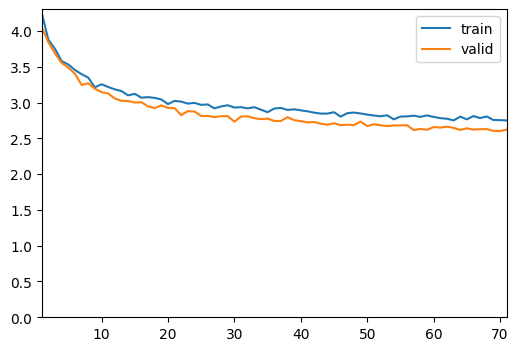

/home/dgj335/.local/lib/python3.10/site-packages/fastprogress/fastprogress.py:206: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  if x_bounds is not None: self.graph_ax.set_xlim(*x_bounds)


Loss is nan, skipping batch
Loss is nan, skipping batch
Loss is nan, skipping batch
Loss is nan, skipping batch
Loss is nan, skipping batch
Loss is nan, skipping batch
Epoch: 2, Accuracy: 0.1499
Loss is nan, skipping batch
Loss is nan, skipping batch
Epoch: 3, Accuracy: 0.1891
Loss is nan, skipping batch
Loss is nan, skipping batch
Loss is nan, skipping batch
Loss is nan, skipping batch
Loss is nan, skipping batch
Loss is nan, skipping batch
Epoch: 4, Accuracy: 0.2178
Loss is nan, skipping batch
Epoch: 5, Accuracy: 0.2373
Loss is nan, skipping batch
Loss is nan, skipping batch
Loss is nan, skipping batch
Epoch: 6, Accuracy: 0.2348
Loss is nan, skipping batch
Loss is nan, skipping batch
Loss is nan, skipping batch
Epoch: 7, Accuracy: 0.2670
Loss is nan, skipping batch
Loss is nan, skipping batch
Epoch: 8, Accuracy: 0.2782
Loss is nan, skipping batch
Loss is nan, skipping batch
Loss is nan, skipping batch
Loss is nan, skipping batch
Loss is nan, skipping batch
Loss is nan, skipping batch

In [ ]:
epochs = 200
mb = master_bar(range(1, epochs + 1))
train_loss = []
test_loss = []
val_accuracy = []
augmentations = Compose([
    RandomCrop(12),
    RandomHorizontalFlip(0.5),
    RandomErasing(p=0.5, scale=(1/144, 16/144), ratio=(1/12, 12), value= 0      , inplace=False),
    RandomErasing(p=0.5, scale=(1/144, 16/144), ratio=(1/12, 12), value= 0      , inplace=False),
    RandomErasing(p=0.5, scale=(1/144, 16/144), ratio=(1/12, 12), value='random', inplace=False),
    RandomErasing(p=0.5, scale=(1/144, 16/144), ratio=(1/12, 12), value='random', inplace=False)
])

center_crop = CenterCrop(12)

for epoch in mb:
    # Training Phase
    dataloader_train = DataLoader(dataset['train'], batch_size=256, shuffle=True, drop_last=True)
    model.train()
    running_loss = 0.0
    for inputs in progress_bar(dataloader_train, parent=mb):
        x = augmentations(inputs['latent'].cuda())
        targets = inputs['label'].to(torch.int64).cuda()
        optimizer.zero_grad()
        outputs = model(x)
        loss = loss_function(outputs, targets)
        if torch.isnan(loss):
            print(f"Loss is nan, skipping batch")
            continue
        loss.backward()
        print(loss.item(), end='\r')
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        running_loss += loss.item()

    train_epoch_loss = running_loss / len(dataloader_train)
    train_loss.append(train_epoch_loss)
    
    # Validation Phase
    dataloader_val = DataLoader(dataset['validation'], batch_size=256, shuffle=False, drop_last=False)
    model.eval()
    running_loss_val = 0.0
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        for inputs in dataloader_val:
            x = center_crop(inputs['latent'].cuda())
            targets = inputs['label'].to(torch.int64).cuda()
            outputs = model(x)
            loss = loss_function(outputs, targets)
            if torch.isnan(loss):
                print(f"Loss is nan, skipping batch")
                continue
            running_loss_val += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == targets).sum().item()
            total_predictions += targets.size(0)
    val_epoch_loss = running_loss_val / len(dataloader_val)
    test_loss.append(val_epoch_loss)
    epoch_accuracy = correct_predictions / total_predictions
    print(f'Epoch: {epoch}, Accuracy: {epoch_accuracy:.4f}')
    val_accuracy.append(epoch_accuracy)
    graphs = [
        [range(1, epoch + 1), train_loss],  # Training Loss
        [range(1, epoch + 1), test_loss],  # Validation Loss
    ]
    x_bounds = [1, epoch]
    y_bounds = [min(min(train_loss + test_loss) - 0.05, 0), max(max(train_loss + test_loss) + 0.05, 1)]
    mb.update_graph(graphs, x_bounds, y_bounds)
    checkpoint_filename = f'checkpoint{epoch}.pt'
    torch.save(model.state_dict(), checkpoint_filename)